In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, bernoulli
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0

    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1


class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale # controls width of the gaussian
        self.reg = reg #regularization parameter to be added to the diagonal of the kernel matrix
        self.k_xx_inv = None # stores inverse of kernel function

    def rbf_kernel_incr_inv(self, B, C, D):
        """_summary_

        Args:
            B : The kernel values between existing training data and new data points
            C : B transposed
            D : Regularization term

        Returns:
            inverse of the kernel matrix online
        """
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)

    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

class StochasticPricingEnvironment1:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t1, p_t2, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t1, p_t2))
        r_t = (p_t1 - self.cost)*d_t
        return d_t, r_t

class StochasticPricingEnvironment2:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t1, p_t2, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t1, p_t2))
        r_t = (p_t2 - self.cost)*d_t
        return d_t, r_t

In [ ]:
n_customers = 200
cost = 0.5
T= 500
K=10

Substitution Effect

In [ ]:
cp1 = lambda p1, p2: 1-p1
cp2 = lambda p1, p2: np.minimum(np.maximum(0, 1 - p2 + 0.4 * p1), 1)

In [ ]:
gp1_agent = GPUCBAgent(T, discretization=K)
env1 = StochasticPricingEnvironment1(cp1, cost)

gp2_agent = GPUCBAgent(T, discretization=K)
env2 = StochasticPricingEnvironment2(cp2, cost)

arms1 = np.array([0.5])
arms2 = np.array([0.5])

for t in range(T):

    p_t1 = gp1_agent.pull_arm()
    d_t1, r_t1 = env1.round(p_t1, arms2[-1], n_customers)

    arms1 = np.append(arms1, p_t1)
    gp1_agent.update(r_t1/n_customers)

    p_t2 = gp2_agent.pull_arm()
    d_t2, r_t2 = env2.round(arms1[-1], p_t2, n_customers)

    arms2 = np.append(arms2, p_t2)
    gp2_agent.update(r_t2/n_customers)

Text(0.5, 1.0, 'Substitution Effect')

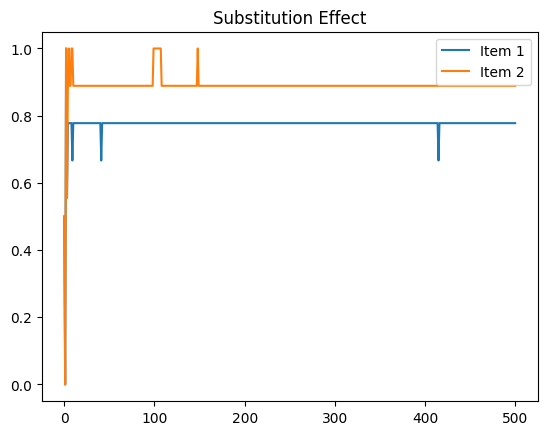

In [ ]:
plt.plot(np.arange(T+1), arms1, label = 'Item 1')
plt.plot(np.arange(T+1), arms2, label = 'Item 2')
plt.legend()
plt.title('Substitution Effect')

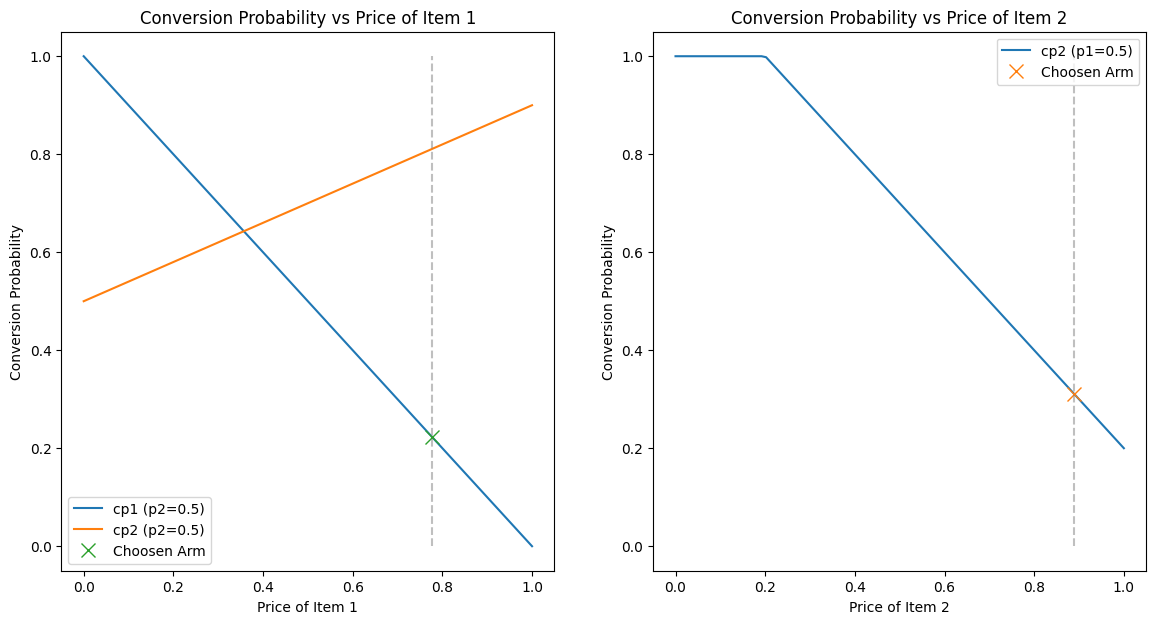

In [ ]:
p_range = np.linspace(0, 1, 100)

p2_fixed = 0.5
cp1_values_p1 = cp1(p_range, p2_fixed)
cp2_values_p1 = cp2(p_range, p2_fixed)

p1_fixed = 0.5
cp2_values_p2 = cp2(p1_fixed, p_range)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].plot(p_range, cp1_values_p1, label='cp1 (p2=0.5)')
axes[0].plot(p_range, cp2_values_p1, label='cp2 (p2=0.5)')
axes[0].set_title('Conversion Probability vs Price of Item 1')
axes[0].set_xlabel('Price of Item 1')
axes[0].set_ylabel('Conversion Probability')
axes[0].plot(np.average(arms1[-100:-1]), np.average(cp1(arms1[-100:-1], 0.5)), 'x', markersize = 10,  label = 'Choosen Arm')
axes[0].vlines(np.average(arms1[-100:-1]), 0, 1, linestyle = '--', color='grey', alpha = 0.5)
axes[0].legend()


axes[1].plot(p_range, cp2_values_p2, label='cp2 (p1=0.5)')
axes[1].set_title('Conversion Probability vs Price of Item 2')
axes[1].set_xlabel('Price of Item 2')
axes[1].set_ylabel('Conversion Probability')
axes[1].plot(np.average(arms2[-100:-1]), np.average(cp2(0.5, arms2[-100:-1])), 'x', markersize = 10, label = 'Choosen Arm')
axes[1].vlines(np.average(arms2[-100:-1]), 0, 1, linestyle = '--', color='grey', alpha = 0.5)
axes[1].legend()

plt.show()

Complementary Products

In [ ]:
cp1 = lambda p1, p2: 1-p1
cp2 = lambda p1, p2: np.minimum(np.maximum(0, 1 - p2 - 0.4 * p1),1)

In [ ]:
gp1_agent = GPUCBAgent(T, discretization=K)
env1 = StochasticPricingEnvironment1(cp1, cost)

gp2_agent = GPUCBAgent(T, discretization=K)
env2 = StochasticPricingEnvironment2(cp2, cost)

arms1 = np.array([0.5])
arms2 = np.array([0.5])

for t in range(T):

    p_t1 = gp1_agent.pull_arm()
    d_t1, r_t1 = env1.round(p_t1, arms2[-1], n_customers)

    arms1 = np.append(arms1, p_t1)
    gp1_agent.update(r_t1/n_customers)

    p_t2 = gp2_agent.pull_arm()
    d_t2, r_t2 = env2.round(arms1[-1], p_t2, n_customers)

    arms2 = np.append(arms2, p_t2)
    gp2_agent.update(r_t2/n_customers)

Text(0.5, 1.0, 'Complementary Effect')

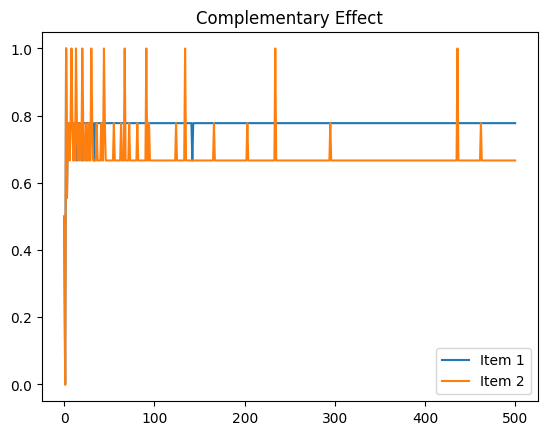

In [ ]:
plt.plot(np.arange(T+1), arms1, label = 'Item 1')
plt.plot(np.arange(T+1), arms2, label = 'Item 2')
plt.legend()
plt.title('Complementary Effect')

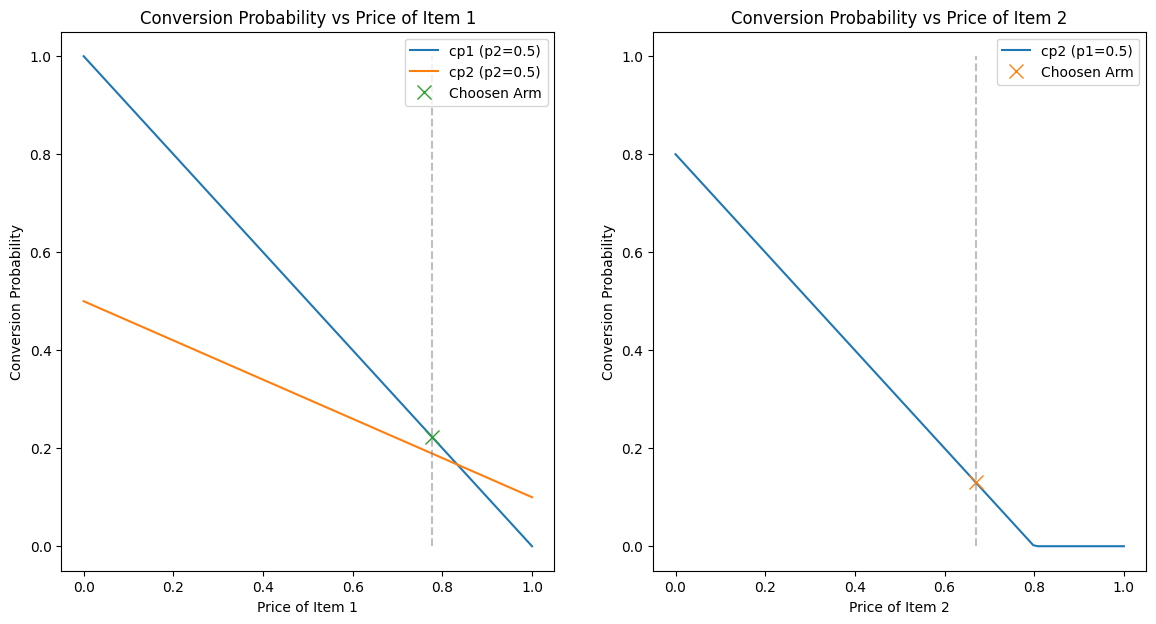

In [ ]:
p_range = np.linspace(0, 1, 100)

p2_fixed = 0.5
cp1_values_p1 = cp1(p_range, p2_fixed)
cp2_values_p1 = cp2(p_range, p2_fixed)

p1_fixed = 0.5
cp2_values_p2 = cp2(p1_fixed, p_range)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].plot(p_range, cp1_values_p1, label='cp1 (p2=0.5)')
axes[0].plot(p_range, cp2_values_p1, label='cp2 (p2=0.5)')
axes[0].set_title('Conversion Probability vs Price of Item 1')
axes[0].set_xlabel('Price of Item 1')
axes[0].set_ylabel('Conversion Probability')
axes[0].plot(np.average(arms1[-100:-1]), np.average(cp1(arms1[-100:-1], 0.5)), 'x', markersize = 10,  label = 'Choosen Arm')
axes[0].vlines(np.average(arms1[-100:-1]), 0, 1, linestyle = '--', color='grey', alpha = 0.5)
axes[0].legend()


axes[1].plot(p_range, cp2_values_p2, label='cp2 (p1=0.5)')
axes[1].set_title('Conversion Probability vs Price of Item 2')
axes[1].set_xlabel('Price of Item 2')
axes[1].set_ylabel('Conversion Probability')
axes[1].plot(np.average(arms2[-100:-1]), np.average(cp2(0.5, arms2[-100:-1])), 'x', markersize = 10, label = 'Choosen Arm')
axes[1].vlines(np.average(arms2[-100:-1]), 0, 1, linestyle = '--', color='grey', alpha = 0.5)
axes[1].legend()

plt.show()

Independent

In [ ]:
cp1 = lambda p1, p2: 1-p1
cp2 = lambda p1, p2: 1-p2

In [ ]:
gp1_agent = GPUCBAgent(T, discretization=K)
env1 = StochasticPricingEnvironment1(cp1, cost/2)

gp2_agent = GPUCBAgent(T, discretization=K)
env2 = StochasticPricingEnvironment2(cp2, cost)

arms1 = np.array([0.5])
arms2 = np.array([0.5])

for t in range(T):

    p_t1 = gp1_agent.pull_arm()
    d_t1, r_t1 = env1.round(p_t1, arms2[-1], n_customers)

    arms1 = np.append(arms1, p_t1)
    gp1_agent.update(r_t1/n_customers)

    p_t2 = gp2_agent.pull_arm()
    d_t2, r_t2 = env2.round(arms1[-1], p_t2, n_customers)

    arms2 = np.append(arms2, p_t2)
    gp2_agent.update(r_t2/n_customers)


Text(0.5, 1.0, 'Different Cost Scenario')

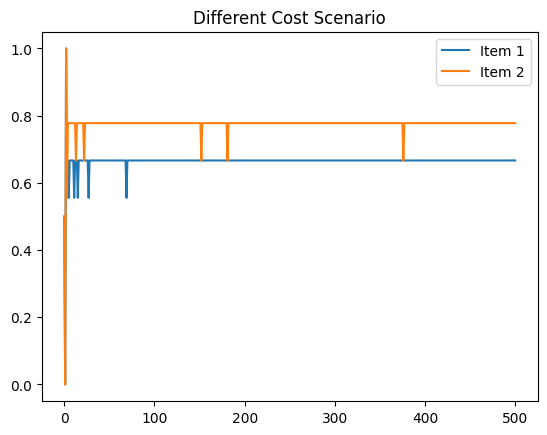

In [ ]:
plt.plot(np.arange(T+1), arms1, label = 'Item 1')
plt.plot(np.arange(T+1), arms2, label = 'Item 2')
plt.legend()
plt.title('Different Cost Scenario')

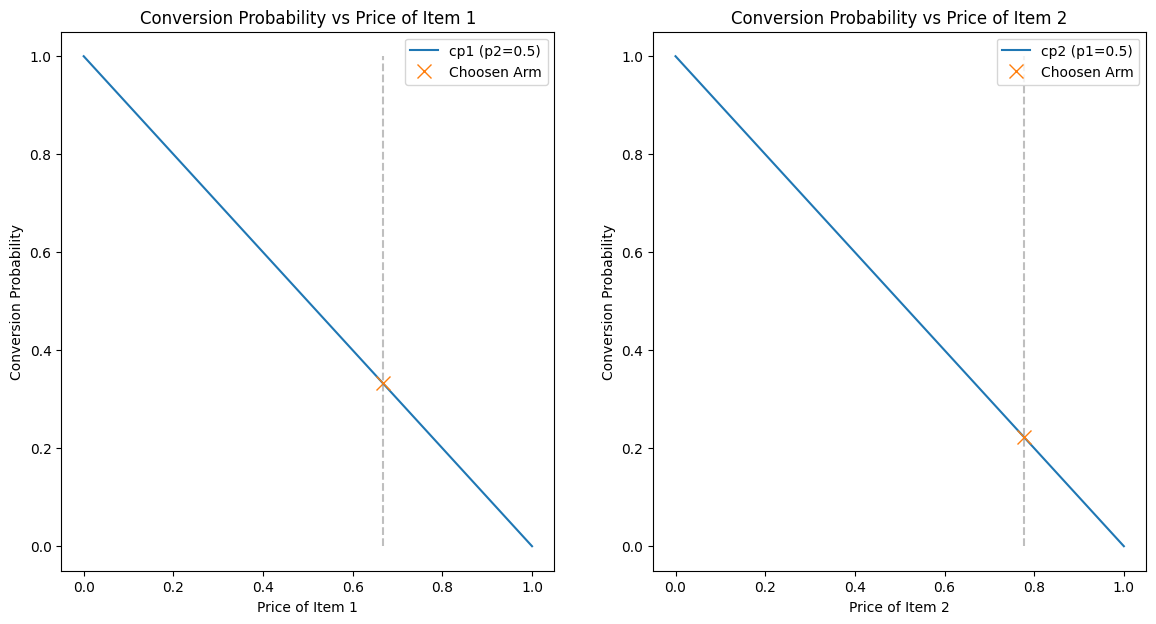

In [ ]:
p_range = np.linspace(0, 1, 100)

p2_fixed = 0.5
cp1_values_p1 = cp1(p_range, p2_fixed)

p1_fixed = 0.5
cp2_values_p2 = cp2(p1_fixed, p_range)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].plot(p_range, cp1_values_p1, label='cp1 (p2=0.5)')
axes[0].set_title('Conversion Probability vs Price of Item 1')
axes[0].set_xlabel('Price of Item 1')
axes[0].set_ylabel('Conversion Probability')
axes[0].plot(np.average(arms1[-100:-1]), np.average(cp1(arms1[-100:-1], 0.5)), 'x', markersize = 10,  label = 'Choosen Arm')
axes[0].vlines(np.average(arms1[-100:-1]), 0, 1, linestyle = '--', color='grey', alpha = 0.5)
axes[0].legend()


axes[1].plot(p_range, cp2_values_p2, label='cp2 (p1=0.5)')
axes[1].set_title('Conversion Probability vs Price of Item 2')
axes[1].set_xlabel('Price of Item 2')
axes[1].set_ylabel('Conversion Probability')
axes[1].plot(np.average(arms2[-100:-1]), np.average(cp2(0.5, arms2[-100:-1])), 'x', markersize = 10, label = 'Choosen Arm')
axes[1].vlines(np.average(arms2[-100:-1]), 0, 1, linestyle = '--', color='grey', alpha = 0.5)
axes[1].legend()

plt.show()